In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
tf.__version__

'1.14.0'

In [3]:
# installing dev libraries
!pip install git+https://github.com/scikit-learn/scikit-learn.git

  Cloning https://github.com/scikit-learn/scikit-learn.git to /tmp/pip-req-build-0f2uszx4
  Running command git clone -q https://github.com/scikit-learn/scikit-learn.git /tmp/pip-req-build-0f2uszx4
  Created wheel for scikit-learn: filename=scikit_learn-0.22.dev0-cp36-cp36m-linux_x86_64.whl size=16642114 sha256=912398274a72156d02ec5fd960647334dd2702b66db99562efc14b94bfcec3c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-18ym49ce/wheels/7a/25/c4/63026649a3d39acb6ae783b2c72fcbe96f4ed2aa61c33edc1b
Successfully built scikit-learn
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


In [1]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import LeakyReLU, ELU, ReLU
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve, roc_auc_score

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### load and split the data set into relavant train test sets 

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# from the shapes, we can expect to see images of 32 x 32 pixels
# this is very small but hopefully enough to learn some features. 

# there are 50,000 images in the training set and 10000 images in the test set, same pixel size
# they are coloured images (repersented by the 3 in (50000, 32, 32, 3) which could 
# be better than training against black n white give the image size. 

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


### viusalisation of data checking the categories of labels that we have

In [0]:
label_num = list(set(tuple(label)[0] for label in y_train))
label_num.sort()
label_num

# we can see that 10 classes are present
# just to make life easier for us we are going to convert this into
# a dict object so we can refer back to it later. 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [0]:
# these classes are taken from the cifar-10 website and documentation. 
label_word = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# creating the dict obj
label_dict = {num: name for num, name in list(zip(label_num, label_word))}

label_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

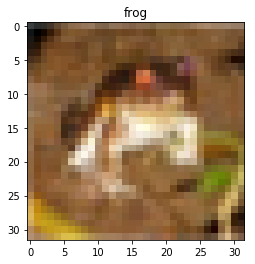

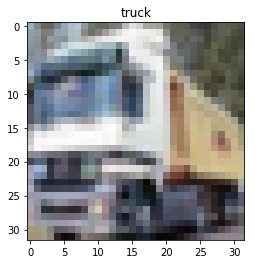

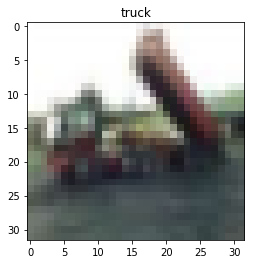

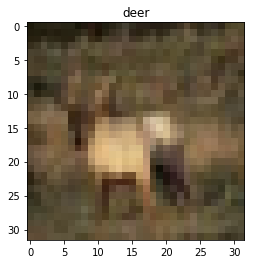

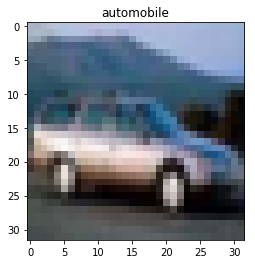

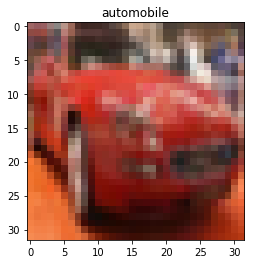

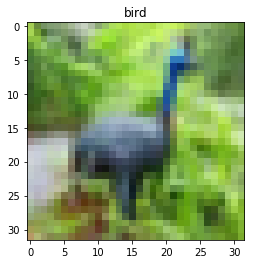

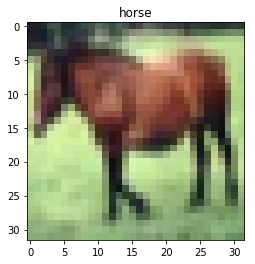

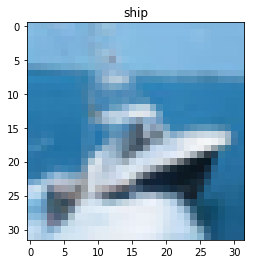

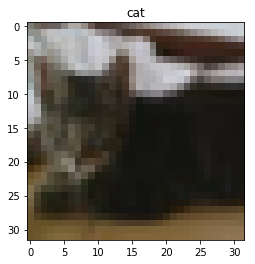

In [0]:
for i in range(10):
    plt.imshow(x_train[i])
    
    #adding the title 
    plt.title(label_dict[y_train[i][0]])

    plt.show()

# that picture quality tho... 
# but from the images we can see that the label correspond properly


In [0]:
# creating a image counter to see the distribution of images and measure spread of classes
image_count = {}

for i in y_train:
    if i[0] in label_num:
        if i[0] in image_count.keys(): 
            image_count[i[0]] += 1
        else:
            image_count[i[0]] = 1
            
# from this print statement below we can clearly see that all classes are even and there is no imbalance problem.
print(image_count)    

{6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}


Text(0, 0.5, 'number of training images')

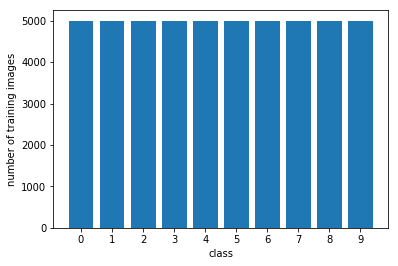

In [0]:
# just to confirm and make it visually understandable 
plt.bar(list(image_count.keys()), list(image_count.values()))
plt.xticks(list(image_count.keys()))

plt.xlabel('class')
plt.ylabel('number of training images')

### data preprocessing

0
255


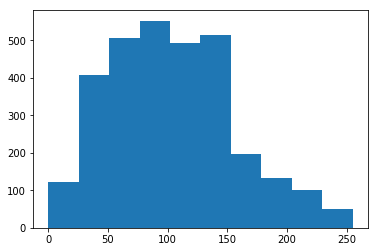

In [0]:
# normalisation is quite important in any ML use case
# normalisation is the process of evening out the inputs
# of the model, within a certain range either -1 --> +1 or
# 0 --> +1 to ensure that there isnt any off shoot during training.
# this also ensures that the attributes are treated evenly by the model. 

# if we do a histogram and min/max of our pixel values of the model 
# we can see the range is from 0 --> 255. 

plt.hist(x_train[0].flatten())
print(min(x_train[0].flatten()))
print(max(x_train[0].flatten()))


In [0]:
# we can simply divide these values by 255 to get values between 0-1
x_train, x_test = x_train/255., x_test/255.

0.0
1.0


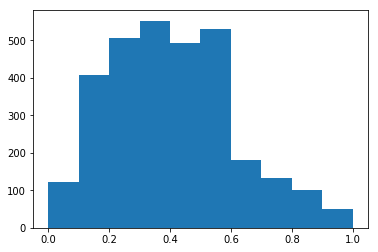

In [0]:
# now checking the shaped annd plotting the above graph and extracting
# min/max values from our datasets

plt.hist(x_train[0].flatten())
print(min(x_train[0].flatten()))
print(max(x_train[0].flatten()))

## Building and Tuning model Manually 

The Cifar-10 dataset is commonly used as a benchmark for testing newly developed architectures. It contains 60,000 images
in total across 10 classes. For our purposes the data is split into 50,000 training and 10,000 testing. 
For these experiments the metric we chose to track is accuracy as it repersents the output perfectly. We have a balanced number of 
training samples per class. We will look at some in-depth methods like confusions matrix etc later on. 

Initially I experimented with tuning the number of filters in each convolutional layer. In my experience, I start off with a large number,
like 256 and half it the next layer. In this case, the image size wasvery small, only 32x32 so therefore I decided to start with 32 filters in the first Conv2D layer and in the next 2 layers, 16 and 8 filters. 

The kernel size and stride were very important aswell and i started off with the usual 3x3 kernel size with a tride of 1. This was so
that there is still some image left for the model to extract high level detail out of. These param values were kept for all 3 conv2d layers. 
This gave us a baseline Validation accuracy of 66%.

Next step was increasing the filters as i thought about how many different edges, curves, corners could be present in 50,000 images. Found Validation accuracy level off at ~73% with 128, 64 and 32 filters per layer. 

After this I adjusted the nodes in the dense layer. As there is no golden rule, i used a trusted formula (used in academic research) which is nodes = (number of attributes + number of classes) / 2. this bought the accuracy to ~70% but as i scaled down so i added another dense layer 
which didnt seen to help. Sticking with 2 Dense layers and adding 800 / 400 nodes per layer we recieved an Validation accuracy of ~75%.

In academic literature ReLU has been surpasses by LeakyReLu and PRReLU as ReLU has a problem called the 'dying ReLU' problem which outputs the same value (0) for any input. LeakyReLU provided better results (than PRReLU and ReLU) bumping our validation accuracy to ~76%. 

By adjusting our kernel size in our first layer to 4x4, reducing our third Conv2d stride to 1x1 and removing all max pooling layers we achieved and validation accuracy of ~77.3%

The magic ~80.2% val accuracy (and 77% test) came when we started looking at different combinations of dropout values (and luck with random numbers). A dropout layer prevents overfitting by 'dropping out' excessive parameters.

In [5]:
model = Sequential()

# try make filters m x n now instead of a single number

model.add(Conv2D(128, (4, 4), (2, 2), input_shape=(32, 32, 3)))
model.add(LeakyReLU(alpha=0.30))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), (2, 2)))
model.add(LeakyReLU(alpha=0.30))
model.add(Dropout(0.2))


model.add(Conv2D(32, (3, 3), (1, 1)))
model.add(LeakyReLU(alpha=0.30))
model.add(Dropout(0.4))


model.add(Flatten())

model.add(Dense(800))
model.add(LeakyReLU(alpha=0.30))
model.add(Dropout(0.1))

model.add(Dense(400))
model.add(LeakyReLU(alpha=0.30))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

optimizers.SGD(lr = 0.0001)

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



W0811 09:33:46.929653 140701730629504 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
history = model.fit(x_train, y_train, epochs=100, validation_split=0.01)

Train on 49500 samples, validate on 500 samples
Epoch 1/100
49500/49500 [==============================] - 16s 327us/sample - loss: 2.0786 - acc: 0.2301 - val_loss: 1.9132 - val_acc: 0.3460
Epoch 2/100
49500/49500 [==============================] - 13s 256us/sample - loss: 1.8170 - acc: 0.3482 - val_loss: 1.6826 - val_acc: 0.4060
Epoch 3/100
49500/49500 [==============================] - 13s 260us/sample - loss: 1.6809 - acc: 0.3968 - val_loss: 1.5780 - val_acc: 0.4520
Epoch 4/100
49500/49500 [==============================] - 13s 261us/sample - loss: 1.5899 - acc: 0.4272 - val_loss: 1.4901 - val_acc: 0.4780
Epoch 5/100
49500/49500 [==============================] - 13s 254us/sample - loss: 1.5234 - acc: 0.4504 - val_loss: 1.4114 - val_acc: 0.5020
Epoch 6/100
49500/49500 [==============================] - 12s 247us/sample - loss: 1.4714 - acc: 0.4694 - val_loss: 1.3585 - val_acc: 0.5160
Epoch 7/100
49500/49500 [==============================] - 12s 252us/sample - loss: 1.4266 - acc: 0.

In [7]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']

val_acc = history.history['val_acc']
acc = history.history['acc']

print('val loss:', min(val_loss), '| train loss:', min(train_loss))
print('val accuracy:', max(val_acc), '| train acc:', max(acc))

val loss: 0.620858051776886 | train loss: 0.632303127994441
val accuracy: 0.79 | train acc: 0.7760808


In [0]:
predict_hist = model.predict(x_test)

In [9]:
test_hist = model.evaluate(x_test, y_test)
test_hist

10000/10000 [==============================] - 1s 125us/sample - loss: 0.6702 - acc: 0.7595


[0.6701782929420471, 0.7595]

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 128)       6272      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 15, 15, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          1

# Implementing random search

Hyper parameter tuning is a lengthy and tedious process of guessing what param values are best to use with your model. A search algorithm automates this task and finds combinations that give the best results (within limits). 

I chose to implement Random search as that 'randomly' selects params to use and could stumble upon the perfect param combinations as compared to other search methods i.e. grid, genetic etc. Random Search is also memory efficient as compared to grid search. 

With Random Search the highest accuracy I recieve was 73.4% as compared to our 78.6%. But it was good to see this in action and how it saved time as i could let it run for 200 iteration over night. 

In [0]:
def create_model(l1_filter=128, l2_filter=64, l3_filter=32, dense1=800,dense2=400, dense3 =200, act_fun='ELU', 
                lr=0.001, drop1=0.1, drop2=0.2, drop3=0.3, drop4=0.4, drop5=0.5, drop6=0.4):
  
  alpha = 0.33

  search_model = Sequential()

  # try make filters m x n now instead of a single number

  search_model.add(Conv2D(l1_filter, (5, 5), 2, input_shape=(32, 32, 3)))

  if act_fun == 'ELU' or act_fun == 'LeakyReLU':
      search_model.add(act_fun(alpha=alpha))
  else:
      search_model.add(act_fun())

  search_model.add(Dropout(drop1))

  search_model.add(Conv2D(l2_filter, (3, 3), 2))

  if act_fun == 'ELU' or act_fun == 'LeakyReLU':
      search_model.add(act_fun(alpha=alpha))
  else:
      search_model.add(act_fun())

  search_model.add(Dropout(drop2))


  search_model.add(Conv2D(l3_filter, (3, 3), 1))
  
  if act_fun == 'ELU' or act_fun == 'LeakyReLU':
      search_model.add(act_fun(alpha=alpha))
  else:
      search_model.add(act_fun())

  search_model.add(Dropout(drop3))


  search_model.add(Flatten())

  search_model.add(Dense(dense1))
  
  if act_fun == 'ELU' or act_fun == 'LeakyReLU':
      search_model.add(act_fun(alpha=alpha))
  else:
      search_model.add(act_fun())

  search_model.add(Dropout(drop4))

  search_model.add(Dense(dense2))
  
  if act_fun == 'ELU' or act_fun == 'LeakyReLU':
      search_model.add(act_fun(alpha=alpha))
  else:
      search_model.add(act_fun())

  search_model.add(Dropout(drop5))

  search_model.add(Dense(dense3))
  
  if act_fun == 'ELU' or act_fun == 'LeakyReLU':
      search_model.add(act_fun(alpha=alpha))
  else:
      search_model.add(act_fun())
      
  search_model.add(Dropout(drop6))

  search_model.add(Dense(10, activation='softmax'))

  adam = optimizers.Adam(lr = lr)

  search_model.compile(adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  
  return search_model

In [0]:
# Parms to pass into search

l1_filter = [32, 64, 128, 256]
l2_filter = [32, 64, 128, 256]
l3_filter = [32, 64, 128, 256]

dense1 = [600, 200, 400, 800, 100]
dense2 = [600, 200, 400, 800, 100]
dense3 = [600, 200, 400, 800, 100]


act_fun = [ELU, ReLU, LeakyReLU]

lr = [0.001, 0.002, 0.0005, 0.0001, 0.00001, 0.00005, 0.0002, 0.00002]

drop1 = [0.2, 0.3, 0.4, 0.5, 0.6]
drop2 = [0.2, 0.3, 0.4, 0.5, 0.6]
drop3 = [0.2, 0.3, 0.4, 0.5, 0.6]
drop4 = [0.2, 0.3, 0.4, 0.5, 0.6]
drop5 = [0.2, 0.3, 0.4, 0.5, 0.6]
drop6 = [0.2, 0.3, 0.4, 0.5, 0.6]

param_grid = dict(l1_filter=l1_filter, l2_filter=l2_filter, l3_filter=l3_filter,
                  dense1=dense1,dense2=dense2, dense3 =dense3,
                  act_fun=act_fun, 
                  lr=lr, 
                  drop1=drop1, drop2=drop2, drop3=drop3, drop4=drop4, drop5=drop5, drop6=drop6)

In [0]:
model = KerasClassifier(build_fn=create_model, epochs=40, validation_split = 0.05)

In [0]:
rs_model = RandomizedSearchCV(estimator=model, cv=3, param_distributions=param_grid, 
                          verbose = 20, n_iter=40, n_jobs=-1)


In [0]:
search_history = rs_model.fit(x_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [0]:
results = pd.DataFrame(search_history.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr,param_l3_filter,param_l2_filter,param_l1_filter,param_drop6,param_drop5,param_drop4,param_drop3,param_drop2,param_drop1,param_dense3,param_dense2,param_dense1,param_act_fun,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1288.516952,3.193016,6.414476,0.472701,5e-05,64,64,256,0.6,0.4,0.2,0.6,0.3,0.4,800,200,200,<class 'tensorflow.python.keras.layers.advance...,"{'lr': 5e-05, 'l3_filter': 64, 'l2_filter': 64...",0.550789,0.570049,0.560302,0.56038,0.007863,21
1,1207.651551,2.827146,6.517249,0.534123,1e-05,32,64,128,0.6,0.2,0.6,0.2,0.3,0.5,400,100,200,<class 'tensorflow.python.keras.layers.advance...,"{'lr': 1e-05, 'l3_filter': 32, 'l2_filter': 64...",0.398332,0.397792,0.390196,0.39544,0.003715,39
2,1367.376710,2.692758,7.271221,0.207626,5e-05,128,128,32,0.4,0.6,0.3,0.4,0.5,0.3,600,600,100,<class 'tensorflow.python.keras.layers.advance...,"{'lr': 5e-05, 'l3_filter': 128, 'l2_filter': 1...",0.583488,0.597828,0.554842,0.57872,0.017870,19
3,1746.758402,7.438172,7.471539,0.510490,5e-05,256,256,128,0.4,0.5,0.5,0.5,0.3,0.5,800,600,400,<class 'tensorflow.python.keras.layers.advance...,"{'lr': 5e-05, 'l3_filter': 256, 'l2_filter': 2...",0.683866,0.672947,0.674367,0.67706,0.004848,2
4,1358.213804,1.760579,7.063640,0.113886,2e-05,128,64,32,0.2,0.2,0.2,0.3,0.5,0.3,600,800,800,<class 'tensorflow.python.keras.layers.advance...,"{'lr': 2e-05, 'l3_filter': 128, 'l2_filter': 6...",0.481850,0.482390,0.469099,0.47778,0.006142,27
5,1725.628562,3.974737,8.406197,0.168323,0.0001,32,256,256,0.5,0.5,0.6,0.5,0.5,0.6,800,600,800,<class 'tensorflow.python.keras.layers.advance...,"{'lr': 0.0001, 'l3_filter': 32, 'l2_filter': 2...",0.639287,0.622188,0.633865,0.63178,0.007135,11
6,1406.085901,2.551526,8.185762,0.140641,0.0002,128,128,32,0.4,0.4,0.6,0.6,0.5,0.3,100,800,400,<class 'tensorflow.python.keras.layers.advance...,"{'lr': 0.0002, 'l3_filter': 128, 'l2_filter': ...",0.627287,0.617088,0.622885,0.62242,0.004177,14
7,1873.962602,9.309043,8.655370,0.553688,5e-05,256,256,128,0.4,0.4,0.2,0.3,0.3,0.3,600,800,200,<class 'tensorflow.python.keras.layers.advance...,"{'lr': 5e-05, 'l3_filter': 256, 'l2_filter': 2...",0.647327,0.669947,0.668367,0.66188,0.010311,6
8,1467.238386,0.904160,5.467071,1.121933,5e-05,256,32,128,0.6,0.6,0.3,0.6,0.4,0.3,100,100,600,<class 'tensorflow.python.keras.layers.advance...,"{'lr': 5e-05, 'l3_filter': 256, 'l2_filter': 3...",0.554929,0.557509,0.553042,0.55516,0.001831,22
9,1026.018989,9.135847,5.686655,0.118231,1e-05,32,64,32,0.5,0.4,0.4,0.6,0.4,0.2,400,600,800,<class 'tensorflow.python.keras.layers.advance...,"{'lr': 1e-05, 'l3_filter': 32, 'l2_filter': 64...",0.381952,0.382132,0.375075,0.37972,0.003285,40


In [0]:
results.to_csv('/content/drive/My Drive/Colab Notebooks/RandomSearch5.csv')
print(True)

True


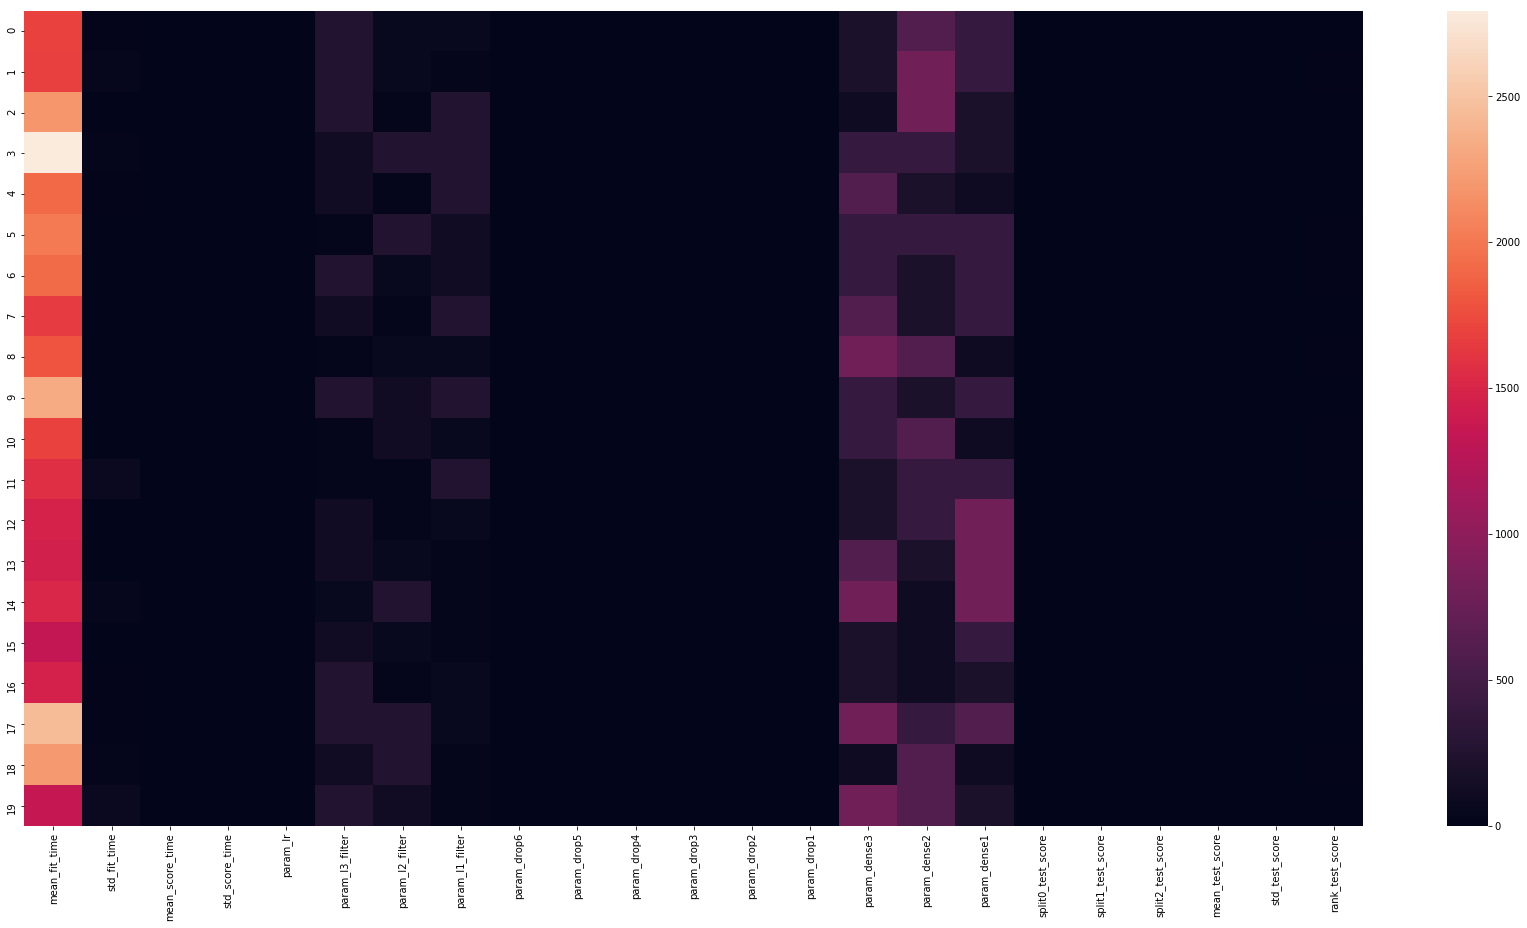

In [0]:
# removing any non int castable columns and converting rest to a numeric column for heatmap analysis
heatmap_df = results.drop(['param_act_fun', 'params'], axis=1)
heatmap_df = heatmap_df.apply(pd.to_numeric)

# this heat map analysis will allow us to find which params coreelate to our column 'mean_test_score'
# then we can go back to our parameter distribution and make changes as needed to increase the chance of higher test accuracy. 
plt.figure(figsize=(30,15))
sns.heatmap(heatmap_df)

In [0]:
temp_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/RandomSearch2.csv')
temp_df

In [0]:
dir(search_history)

In [0]:
print(dir(search_history.best_estimator_)[::-1])
search_history.best_estimator_

# Model output visualisation

We are only viusualising the 78.6% accuracy model. 

Text(0.5, 1.0, 'Train and Val loss over time.')

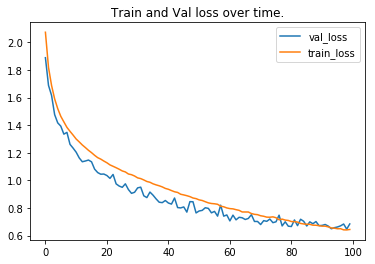

In [0]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']

plt.plot(val_loss)
plt.plot(train_loss)

plt.legend(('val_loss', 'train_loss'))
plt.title('Train and Val loss over time.')

Text(0.5, 1.0, 'train and val accuracy over time')

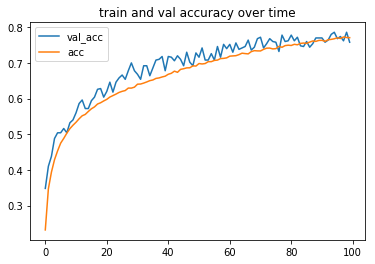

In [0]:
val_acc = history.history['val_acc']
acc = history.history['acc']

plt.plot(val_acc)
plt.plot(acc)

plt.legend(('val_acc', 'acc'))
plt.title('train and val accuracy over time')

In [0]:
# get the argmax of each prediction made by our model. 
# some data prep. We can use numpy array too but wanted to stick with 
# industry naming conventions.

y_pred = [(np.argmax(i)) for i in predict_hist]
y_true = [i for j in y_test for i in j]

report = classification_report(y_true ,y_pred, target_names=label_dict.values())
print(report)

              precision    recall  f1-score   support

    airplane       0.81      0.79      0.80      1000
  automobile       0.87      0.86      0.87      1000
        bird       0.74      0.60      0.66      1000
         cat       0.60      0.54      0.57      1000
        deer       0.71      0.74      0.73      1000
         dog       0.65      0.66      0.66      1000
        frog       0.69      0.91      0.78      1000
       horse       0.83      0.82      0.83      1000
        ship       0.86      0.84      0.85      1000
       truck       0.83      0.83      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



AxesSubplot(0.125,0.125;0.62x0.755)


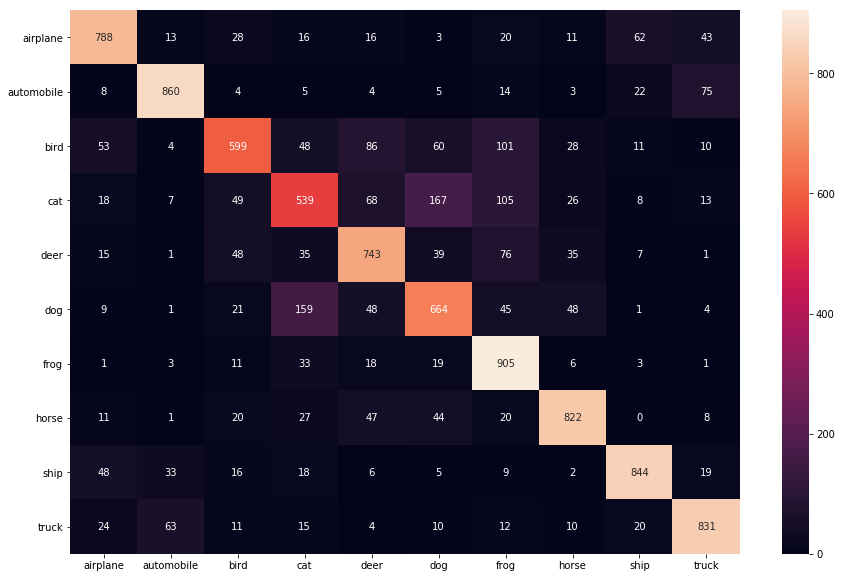

In [0]:
fig, ax = plt.subplots(figsize=(15,10))

conf_matrix = sns.heatmap(confusion_matrix(y_true, y_pred), 
                          annot=True, 
                          ax=ax, 
                          xticklabels=label_dict.values(), 
                          yticklabels=label_dict.values(),
                          fmt='.4g'
                          )
print(conf_matrix)

From the confusion matrix we can see how the classes were predicted and if the model had any overlap. 

The biggest overlap, as guessed, was within cat and dog as at 32x32 pixels these would look very similar. It seems there needs to be a higher level  of abstraction for this. 

there seems to be no issue with predicting the Frog class as it got almost all right. 

These observations can be confirmed by the above precision, recall and f1 scores. 
Put simply, Precision calculates how accurate a model is in predicting True values that are actually True. Precision = TP / TP + FP
Recall calculates how many of the True labelled by the model were actually True. Recall = TP / TP + FN
The F1 score is a function of Precision and Recall and is used when data is unbalanced.


# Saving model

### house keeping stuff 

In [0]:
model.save(f'/content/drive/My Drive/Colab Notebooks/model loss {min(val_loss)} and acc {max(val_acc)}.h5')

In [0]:
ready_model = load_model('/content/drive/My Drive/Colab Notebooks/model loss 0.5925337381362915 and acc 0.8019999861717224.h5')

W0808 02:40:32.270252 140389772195712 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0808 02:40:32.272286 140389772195712 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0808 02:40:32.273991 140389772195712 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

In [0]:
print(ready_model.to_json())

{"class_name": "Sequential", "config": {"name": "sequential_11", "layers": [{"class_name": "Conv2D", "config": {"name": "conv2d_33", "trainable": true, "batch_input_shape": [null, 32, 32, 3], "dtype": "float32", "filters": 128, "kernel_size": [4, 4], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "LeakyReLU", "config": {"name": "leaky_re_lu_55", "trainable": true, "dtype": "float32", "alpha": 0.30000001192092896}}, {"class_name": "Dropout", "config": {"name": "dropout_50", "trainable": true, "dtype": "float32", "rate": 0.1, "noise_shape": null, "seed": null}}, {"class_nam